# 개고양이 이미지 분류와 데이터 부풀리기 실습

설명: 캐글의 개고양이 데이터셋을 사용하여 개고양이 이미지 분류하는 모델을 만들어보겠습니다.

참고: https://keras.io/examples/vision/image_classification_from_scratch/

## 소개

본 실습 예제는 미리 학습된 웨이트를 사용하거나 케라스에서 제공하는 어플리케이션 모델을 사용하지 않고, 이미지 파일을 이용하여 처음부터 모델을 어떻게 학습하는 지를 보여줍니다. 캐글의 개고양이 이진 분류 데이터셋을 사용합니다.

특히 아래 두 가지에 대해서 배울 예정입니다.
* 이미지 파일로부터 모델을 학습하기 위한 데이터셋을 만들기 위해 `image_dataset_from_directory` 함수 사용하는 법을 배웁니다.
* 이미지 표준화(standardization)와 데이터 부풀리기(data augmentation)을 위해 케라스 이미지 전처리 레이어 사용하는 법을 배웁니다.

## 필요한 패키지 불러오기


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 데이터 로딩하기 : 캐글 개고양이 데이터셋

### 원본 데이터 다운로드

먼저 원본 데이터를 다운로드 받아보겠습니다. 원본 파일은 786Mb 용량이며, zip으로 압축되어 있습니다.

* ! 키워드를 통해서 시스템 명령을 코랩에서 실행할 수 있습니다.
* curl은 Client URL의 약자로 http, https, ftp 등에서 제공하는 파일을 쉽게 다운로드 받을 수 있는 툴입니다.
*  -O 옵션은 원격지(서버)에 있는 파일명과 동일한 파일명으로 로컬에 저장하도록 합니다.
* 셀 출력 창에서는 다운로드 진행상황을 보실 수 있습니다.

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   264M      0  0:00:02  0:00:02 --:--:--  264M


다운로드가 완료되면, 코랩의 파일탐색기에서 해당 파일이 정상적으로 다운로드된 것을 확인할 수 있습니다.

* 먼저 다운로드 받은 캐글 개고양이 압축파일을 압축해제합니다.
* 압축해제는 `unzip` 명령으로 쉽게할 수 있습니다.
* -q 옵션은 quiet mode을 의미하며, 이 옵션을 사용하면 압축해제 과정이 출력되지 않습니다. 
* ls 명령을 통해 압축해제된 파일 목록을 확인할 수 있습니다.

In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


* `PetImages` 폴더를 확인할 수 있는 데, 이 폴더는 두 개의 하위 폴더(`Cat`, `Dog`)를 포함하고 있습니다.
* 각 하위 폴더는 해당 카테고리(개와 고양이)에 맞는 이미지 파일을 포함하고 있습니다. 

In [4]:
!ls PetImages

Cat  Dog


### 깨진 이미지 파일 걸러내기

실제 이미지 파일을 다루다보면, 이미지 파일이 깨진 경우가 종종 있습니다. 현재 캐글의 개고양이 데이터셋에서도 깨진 이미지 파일을 가지고 있기 때문에, 이를 걸러내도록 합니다. 

걸러내는 방법은 이미지 헤더에 "JFIF" 문자열이 포함되어 있는 지 검사하여, 포함되어 있지 않다면, 깨진 이미지로 인식합니다.

In [5]:
import os

num_skipped = 0

for folder_name in ("Cat", "Dog"):

    # os.path.join 함수는 파일 경로를 조합해주는 함수입니다.
    # for문에 의해 PetImages/Cat과 PetImages/Dog 두 폴더 이름을 만듭니다.
    folder_path = os.path.join("PetImages", folder_name)

    # os.listdir 함수로 해당 경로의 파일 목록을 가져올 수 있습니다.
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")

            # tf.compat은 호환성에 관련된 함수를 제공하며, 
            # as_bytes 함수는 입력된 문자열을 바이트로 변환합니다.
            # peek 함수는 파일 커서를 옮기지 않고 현재 커서에서 사이즈만큼 데이터를 가져옵니다. 
            # 따라서 파일을 열자마자 peek(10)을 호출하면, 첫 10바이트 만큼의 데이터를 가져옵니다.
            # 첫 10바이트 내에 "JFIF" 문자열 존재 유무를 is_jfif 변수에 저장합니다.
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:

            # "JFIF" 문자열을 포함하지 않으면, num_skipped 값을 증가시킵니다.
            num_skipped += 1

            # 그 후 해당 파일을 os.remove 함수를 통해 삭제합니다.
            os.remove(fpath)

# 총 삭제된 이미지의 수를 출력합니다.
print("Deleted %d images" % num_skipped)

Deleted 1590 images


## 데이터셋 생성하기

파일로부터 데이터셋을 생성하기 위해서, tf.keras.preprocessing.image_dataset_from_directory 함수를 사용합니다.

먼저 주요인자에 대해서 살펴보겠습니다.
* 첫번째 인자: 폴더명입니다. 여기서 지정한 폴더 안에 클래스별로 하위폴더로 구성되어 있어야 합니다. 
* validation_split: 전체 데이터셋 중 검증셋의 비율입니다. 0.2로 설정할 경우 전체의 20%를 검증셋으로 설정한다는 의미입니다.
* subset: validation_split 옵션을 사용할 경우 훈련셋은 "training"으로 검증셋은 "validation"으로 지정하여 선택할 수 있습니다.
* seed: 섞기(shuffling)과 변형(transformations)에 사용되는 랜덤 시드를 지정할 수 있습니다. 
* image_size: 이미지 파일에서 로딩한 후 데이터셋의 샘플을 만들 때, 원하는 이미지 크기로 지정할 수 있습니다. 즉 원본 이미지 파일들의 사이즈가 다르더라도 이 옵션을 통해서 동일한 사이즈의 샘플들을 확보할 수 있습니다. 
* batch_size: 배치사이즈 즉 데이터셋에서 샘플 추출 시, 한 번에 가져오는 샘플들의 갯수를 지정할 수 있습니다. 

이 함수는 tf.data.Dataset 객체를 반환합니다.
* (이미지, 라벨) 튜플 형태로 반환합니다.
* 이미지 형태는 (배치사이즈, 세로, 가로, 채널) 입니다.
* 라벨 형태는 (배치사이즈,) 입니다.
* 라벨은 하위 폴더 수에 따라 0부터 할당됩니다. 즉 하위 폴더가 3개면, 라벨은 0, 1, 2로 할당이 듭니다.

In [6]:
# 데이터셋으로 만들 샘플 이미지의 사이즈를 (180, 180)으로 지정합니다.
image_size = (180, 180)
batch_size = 32

# 훈련셋을 생성합니다. 지정된 폴더의 파일들에서 80%가 훈련셋으로 생성됩니다.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# 검증셋을 생성합니다. 지정된 폴더의 파일들에서 20%가 검증셋으로 생성됩니다.
# 랜덤 시드를 훈련셋 생성 시와 동일하게 고정하면, 검증셋 생성할 때도 훈련셋과 검증셋 분리가 동일하게 이뤄집니다.
# 이로인해 훈련셋과 검증셋을 겹치지 않게 분리할 수 있습니다.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


출력값을 보면, 
* "PetImages" 폴더 내에 하위폴더가 2개 즉 라벨이 2개이고, 23,410 이미지 파일을 찾았다고 나옵니다. 
* 이 중 80%인 18,728개가 훈련셋으로 지정되고
* 나머지 20%인 4,682개가 검증셋으로 지정되었다고 나옵니다.

## 데이터 시각화 하기

훈련셋에서 9개 샘플 이미지를 시각화 해보겠습니다. 
* 라벨 1은 "개" 입니다.
* 라벨 0은 "고양이" 입니다.


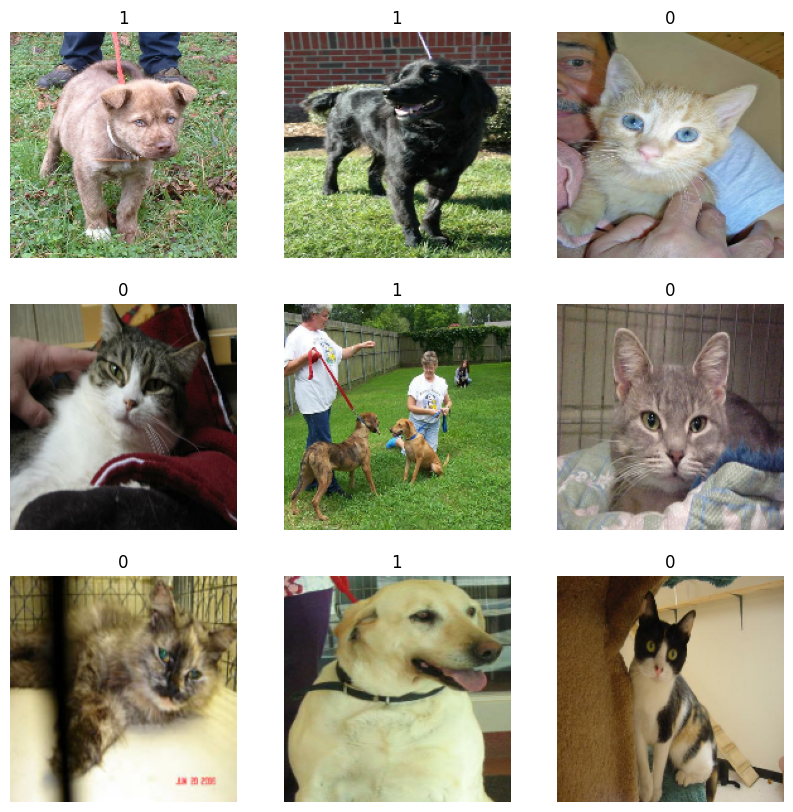

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# 훈련셋에서 1개의 배치를 가지고 온 뒤 순회합니다.
# 1개의 배치 안에는 32개 (배치사이즈가 32이므로) 샘플을 포함하고 있습니다.
for images, labels in train_ds.take(1):

    # 이 중 9개만 순회합니다.
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # 해당 샘플의 이미지를 표출합니다.
        plt.imshow(images[i].numpy().astype("uint8"))

        # 해당 샘플의 라벨을 표시합니다.
        plt.title(int(labels[i]))

        # 깔끔하게 이미지를 표출하기 위해 축은 그리지 않습니다.
        plt.axis("off")


## 데이터 부풀리기 이용하기

만약에 데이터셋이 크지 않은 경우에는 실제로 일어날 법한 변환을 적용해서 샘플의 다양성을 확보합니다. 즉 원본 훈련셋에 대해서 무작위로 좌우반전을 하거나 무작위로 조금씩 회전을 시킨다면 좀 더 다양한 훈련셋을 확보할 수 있습니다.

이를 통해 모델은 다양성이 높은 데이터셋으로 학습할 수 있고, 동시에 과적합을 늦출 수 있습니다. 즉 데이터 부풀리기를 하지 않는다면, 몇 에포크 만에 작은 규모의 훈련셋에만 잘 동작하는 과적합된 모델이 만들어질 수 있습니다. 따라서 우리는 데이터 부풀리기를 통해서 최대한 과적합되는 시점을 늦출 수 있고, 좀 더 높은 성능의 모델을 기대할 수 있습니다.


In [8]:
# 케라스의 시퀀셜 객체로 데이터 부풀리기 레이어를 만들 수 있습니다.
# RandomFlip 레이어에 "horizontal" 옵션을 설정하면 무작위 좌우반전을 시킵니다.
# RandomRotation 레이어에 "0.1" 옵션을 설정하면,
# -36도(= -0.1 * 360도)에서 +36도(= 0.1 * 360도)사이로 무작위 회전을 시킵니다.
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

데이터 부풀리기가 적용된 이미지를 가시화시켜봅니다. 데이터셋 객체를 데이터 부풀리기 레이어에 통과시키면 적용된 이미지를 얻을 수 있습니다.

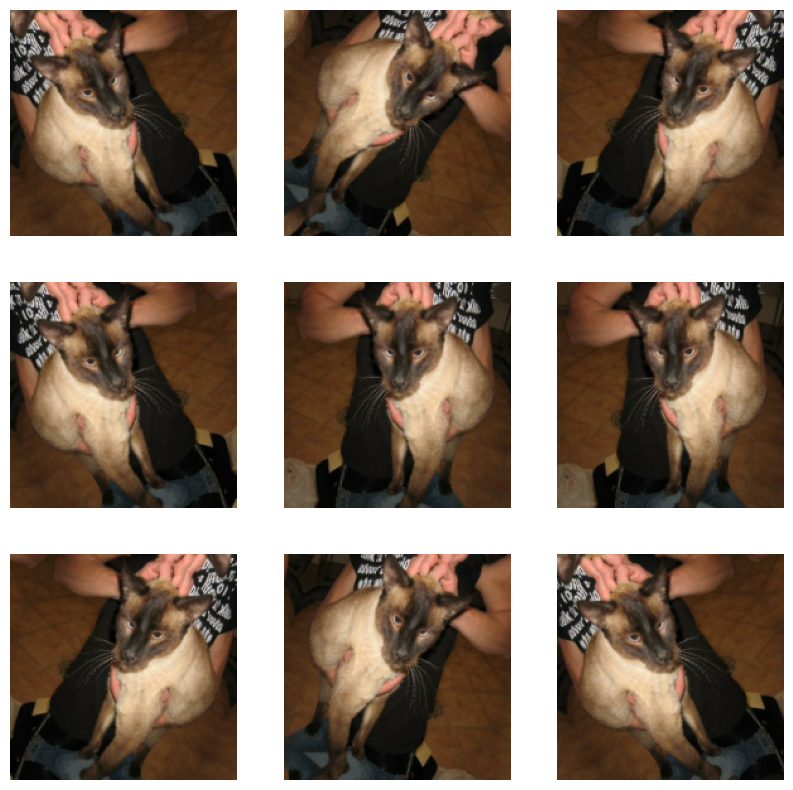

In [9]:
plt.figure(figsize=(10, 10))

# 훈련셋에서 배치 하나를 가져옵니다.
for images, _ in train_ds.take(1):

    # 9번을 반복합니다.
    for i in range(9):

        # 배치 하나에 대해 데이터 부풀리기를 적용합니다.
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)

        # 데이터 부풀리기가 적용된 배치 중 첫번째 이미지를 표출합니다.
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

유사하지만 무작위로 좌우반전과 회전이 적용된 이미지를 보실 수 있습니다. 두 개의 레이어 처리가 모두 적용되기 때문에 여러 조합의 이미지가 생성됩니다. 

## 데이터 표준화시키기

`image_dataset_from_directory`을 통해 만들어진 이미지 샘플은 이미 (180, 180) 사이즈로 표준화된 크기를 가지고 있으며, `float32`인 실수 형태로 수치화 되어 있습니다. 

하지만 이미지의 각 3개 채널(RGB)의 값은 0.0과 255.0사이의 수치로 되어 있으며, 이는 신경망에 적합한 수치가 아닙니다. 일반적으로 입력 수치를 작게 만들어야 하며, 본 예제에서는 `Rescaling` 레이어를 사용하여, 수치들이 0.0과 0.1사이 범주내에 포함될 수 있도록 표준화를 시킵니다.

## 데이터를 전처리하는 두가지 방법

앞서 정의한 `data_augmentation` 전처리기를 사용하는 방법에는 두 가지가 있습니다.

**방법 1: 모델 일부 파트로 만드는 방법**

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

* 데이터 부풀리기 처리 과정이 모델 실행의 다른 파트들과 함께 해당 장비에서 동시에 이뤄지기 때문에 이는 GPU 환경일 경우 GPU 가속 이점을 얻을 수 있습니다. 따라서 GPU 환경에서 학습할 경우에는 첫번째 방법을 권장해드립니다.
* 데이터 부풀리기는 학습 과정에서만 활성화되고 추론 과정에서는 비활성화됩니다. 즉 `fit()` 안에서만 데이터 부풀리기가 적용되고, `evaluate()` 또는 `predict()`에서는 적용되지 않습니다.

**방법 2: 데이터셋에만 적용하는 방법**

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

데이터 부풀리기가 적용된 배치를 반환하는 데이터셋을 확보하는 방법입니다.

* 이 방법은 데이터 부풀리기 처리가 CPU에서 이뤄지며, 비동기적으로 모델에 입력되기 전에 버퍼에 저장되는 방식입니다. 
* 학습 환경이 CPU이라면, 데이터 부풀리기 처리가 비동기적이고 넌블록킹으로 되기 때문에 이 방법을 권장드립니다.
* map 함수를 통해서 lambda 함수를 매핑할 수 있습니다. 
* 위에 정의한 lambda 함수는 이미지인 x는 data_augmentation 함수를 통과시켜서 반환하고, 라벨인 y는 변환없이 그대로 반환합니다. 
* `training=True` 옵션을 통해서 학습 과정 시에만 데이터 부풀리기 처리가 적용되도록 합니다.

## 고성능을 위한 데이터셋 설정

* 입출력에 의한 지연이 생기지 않도록 버퍼사이즈만큼 미리 디스크에서 메모리로 가져옵니다. 이를 prefetch라 합니다.
* 버퍼사이즈를 32로 설정할 경우 미리 32개의 배치를 가져와서 메모리에 적재합니다.

In [10]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## 모델 만들기

본 예제에서는 Xception 신경망의 작은 버전으로 모델을 만들 예정입니다. 따로 모델 아키텍처를 최적화하기 위한 노력은 하지 않았습니다. 만약에 최적화된 하이퍼파라미터를 탐색하려면, 케라스튜너를 참고하세요. >> [KerasTuner](https://github.com/keras-team/keras-tuner).

* 모델은 `data_augmentation` 전처리 레이어로 시작합니다.
* 그 후 `Rescaling` 레이어를 통해 데이터 전처리를 수행합니다.

Xception 신경망은 모델 성능을 높이기 위한 여러가지 기법이 사용되어 있으므로 아래 레이어에 대한 기본적인 이해가 필요합니다.
* `BatchNormalization` 레이어: 배치 정규화는 정규화 방법 중 하나입니다. 기본적으로 정규화를 하는 이유는 학습을 좀 더 빨리하기 위해서, 그리고 지역 최소해에 빠지는 것을 방지하기 위해서 사용합니다. 보통 데이터 전처리 과정에서 정규화를 수행하는 데, 입력 데이터에 대해서 정규화를 수행했다고 하더라도 네트워크를 거치면 데이터 분포가 달라집니다. 배치 정규화는 네트워크 출력에 대해서도 정규화가 이뤄질 수 있도록 하는 기법입니다. 학습 과정에서 입력되는 미니배치에 대해 평균과 분산을 이용해서 정규화 한 뒤에 감마(γ)와 베타(β)에 의해 조정되며, 이 두 값이 학습되는 파라미터입니다. 추론 과정에서는 학습 과정 시에 미리 저장해둔 미니 배치의 평균과 분산의 이동 평균과 학습된 감마와 베타를 이용하여 출력을 계산합니다.
* `Dropout` 레이어: 만약 네트워크가 어떤 특정한 특성에 집중하여 학습이 된다면, 과적합(오버피팅)이 발생합니다. 드랍아웃 레이어는 이를 방지하는 기법 중 하나로 서로 연결된 연결망에서 지정한 확률 만큼 뉴런을 제거하는 것입니다. 학습 과정에서는 미니 배치별로 드랍아웃이 적용되어 매 배치마다 다르게 연결된 망으로 학습됩니다. 추론 과정에서는 드랍되는 뉴런 없이 모든 뉴런이 사용됩니다. 하지만 이대로 사용할 경우 출력값이 높아지므로 출력값을 동일하게 맞추기 위해서 스케일이 적용됩니다. 즉 0.5로 적용되었다면, 학습 과정에서는 50%만 사용된 상태에서 출력이 되었다면, 추론 과정에서는 100%를 모두 사용하게 되므로, 각 뉴론의 출력을 1/2배로 조정해야 출력값이 비슷하게 맞춰질 것입니다.
* `SeparableConv2D` 레이어: 일반적인 Conv2D 레이어에서의 필터는 공간 특성과 채널 특성이 모두 고려되어 학습이 됩니다. SeparableConv2D 레이어는 깊이별 분리 합성곱(depthwise separable convolution)을 수행하며, 여기서 깊이란 채널을 의미합니다. 이 레이어는 두 가지 처리가 이뤄집니다. 첫번째는 입력 채널별로 필터가 독립적으로 할당되어 학습이 됩니다. 이때 공간 방향으로만 합성곱이 이뤄집니다. 필터의 크기는 SeparableConv2D의 두번째 인자인 kernel_size에 따라 정해지나 이 때 사용된 필터의 채널은 1개이며, 필터의 수는 입력 채널의 수와 동일합니다. 그 다음 1x1 합성곱이 이뤄지는 데, 각 점이 가지는 여러 채널의 값에 가중치를 곱하고 그 합이 출력으로 나옵니다. 이를 점별 합성곱(pointwise convolution)이라 부릅니다. 최종적으로 1x1 합성곱을 수행하는 필터의 수(SeparableConv2D의 첫번째 인자인 filters)가 출력 피처맵의 수가 됩니다. 이 기법은 모델 파라미터와 연산의 수를 크게 줄여줍니다.
* 잔차 연결 (Residual connection): 네트워크를 구성할 때, 입력을 순차적으로 연결된 레이어를 통과시켜 출력을 계산하는 것이 일반적입니다. 잔차 연결은 입력을 순차적으로 연결된 레이어를 통과시켜 얻은 출력에다가 입력을 더하여 최종 출력을 얻는 것입니다. 이 기법의 효과는 입력으로부터 출력을 계산할 때, 네트워크 구성에만 의존하는 것이 아니라, 최종 출력을 계산하기 위해서 입력 정보를 그대로 전달하여, 네트워크는 잔차만 학습하면 되도록 구성하도록 하여 좀 더 쉽게 학습시킬 수 있습니다. 잔차 연결된 블록을 여러 개 사용할 경우, 여러가자의 패스를 구성할 수 있어 앙상블 효과도 기대할 수 있습니다. 

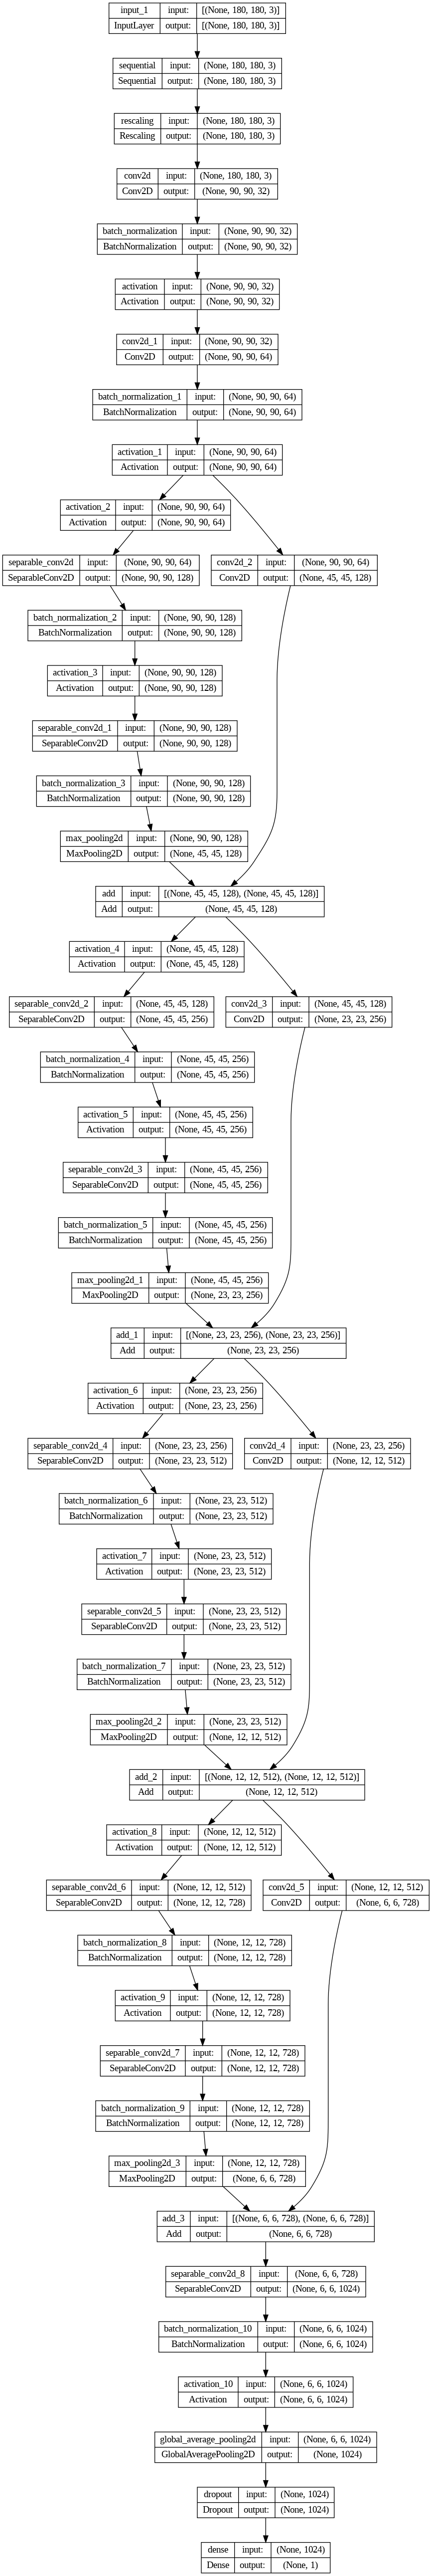

In [11]:
# 모델을 생성하는 코드를 함수로 정의했습니다.
def make_model(input_shape, num_classes):

    # 입력 형태를 지정하여 입력 레이어를 정의합니다.
    inputs = keras.Input(shape=input_shape)
    
    # 데이터 부풀리기 레이어를 지정합니다.
    x = data_augmentation(inputs)

    # 진입 블록을 정의합니다.
    # 가장 처음 Rescaling 레이어를 통과시킵니다. 
    # 이를 통해 0과 255 사이의 수치를 0.0과 1.0 사이 수치로 변환합니다.
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # 잔차 연결을 위해서 블록의 마지막 레이어를 다른 이름으로 저장해둡니다.
    previous_block_activation = x 

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # 이전 블록의 출력에서 잔차를 추출합니다.
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )

        # 이전 레이어의 출력과 잔차를 더 합니다.
        x = layers.add([x, residual])

        # 다음 잔차 연결을 위해 이번 블록의 마지막 레이어를 저장해둡니다.
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # GlobalAveragePooling2D 레이어는 각 채널에 해당하는 피처맵의 평균을 구한 뒤,
    # 각 평균값을 반환한다. 즉 반환되는 값의 수는 입력 채널 수와 동일하다.

    x = layers.GlobalAveragePooling2D()(x)

    # 출력층의 벡처 수와 활성화함수를 지정합니다.
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    # 학습 과정에서 50% 비율로 Dropout을 수행합니다.
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

# 모델 입력을 (180, 180, 3)으로 설정합니다. 
# 클래스 개수는 2개로 지정합니다.
model = make_model(input_shape=image_size + (3,), num_classes=2)

# 케라스의 유틸리티 함수를 이용하여 모델 구조를 시각화 합니다.
keras.utils.plot_model(model, show_shapes=True)

## 모델 학습하기

In [ ]:
epochs = 50

callbacks = [
    # ModelCheckpoint 함수를 통해 매 에포크마다 모델을 파일로 저장할 수 있습니다. 
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

# 옵티마이져는 아담으로 정의하였고, 
# 손실함수로는 이진분류에 사용하는 binary_crossentropy로 지정하였습니다.
# 메트릭은 정확도(accuracy)로 지정하였습니다.
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# 훈련셋을 train_ds으로 지정하고, 검증셋을 val_ds으로 지정하였습니다.
# 콜백함수로는 앞서 정의한 콜백함수를 지정하였습니다.
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 128s 175ms/step - loss: 0.5916 - accuracy: 0.6897 - val_loss: 1.1329 - val_accuracy: 0.5171
Epoch 2/50
586/586 [==============================] - 102s 173ms/step - loss: 0.4259 - accuracy: 0.8065 - val_loss: 0.5333 - val_accuracy: 0.7841
Epoch 3/50
586/586 [==============================] - 103s 176ms/step - loss: 0.3453 - accuracy: 0.8494 - val_loss: 0.4538 - val_accuracy: 0.7982
Epoch 4/50
586/586 [==============================] - 103s 175ms/step - loss: 0.2767 - accuracy: 0.8802 - val_loss: 0.3353 - val_accuracy: 0.8481
Epoch 5/50
586/586 [==============================] - 103s 175ms/step - loss: 0.2320 - accuracy: 0.9027 - val_loss: 0.5062 - val_accuracy: 0.8159
Epoch 6/50
586/586 [==============================] - 103s 175ms/step - loss: 0.2084 - accuracy: 0.9119 - val_loss: 0.2263 - val_accuracy: 0.9060
Epoch 7/50
586/586 [==============================] - 103s 176ms/step - loss: 0.1934 - accuracy: 0.9194 - val_loss: 0.3131 -

50 에포크 학습 후에 검증 정확도는 96% 정도 되었습니다.

## 새로운 데이터를 이용하여 추론하기

추론 단계에서는 `data augmentation`와 `dropout` 레이어는 비활성화가 되어 사용되지 않습니다.


In [ ]:
# 케라스에서 제공하는 함수를 이용하여 특정 이미지 파일을 로딩합니다.
# 로딩된 이미지는 PIL 형식으로 되어 있습니다.
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)

# PIL 형식의 이미지를 numpy 배열로 변환합니다.
img_array = keras.preprocessing.image.img_to_array(img)

# 모델에 입력하기 위해서 batch_size 차원을 추가합니다.
# 변경 전: (height, width, channels)
# 변경 후: (batch_size, height, width, channels)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# 샘플 하나로 구성된 하나의 배치를 모델에 입력합니다.
predictions = model.predict(img_array)

# 모델의 출력은 배치 사이즈 만큼의 0.0과 1.0 사이의 수치를 가지는 벡터값입니다.
# 현재 배치가 1개이므로 첫번째 배치의 수치 벡터를 가지고 옵니다.
score = predictions[0]

# 라벨 0은 고양이를 의미하고, 라벨 1은 개를 의미하므로, 
# 모델 출력의 수치는 입력되는 이미지가 개일 확률로 해석하면 됩니다.
# 고양이의 확률은 1.0에서 개일 확률을 뺀 값입니다.
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

# 마무리

이번 예제에서는 이미지 파일을 이용하여 데이터셋을 구축하는 방법, 데이터 부풀리기를 적용하는 방법, 전처리를 수행하는 방법, 모델을 처음부터 구성하는 방법, 모델 학습 후 실제 추론까지 시켜봤습니다.